## Question 3
### Is there a correlation between types of electric vehicles purchased in Washington state and geographic location?

## Select features to be used for cluster and classification models (i.e. year, make, EV type, income)

In [1]:
# Load dataframes from data_clean.ipynb
%store -r ev_sales_nation_df
%store -r electric_vehicle_df
%store -r charging_stations_df
%store -r income_df

In [2]:
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from yellowbrick.cluster import KElbowVisualizer

In [3]:
electric_vehicle_df.head(5)

,County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Vehicle Location,Electric Utility
0,King,Seattle,98103,2020,HYUNDAI,KONA,Battery Electric Vehicle (BEV),CAFV Eligible,POINT (-122.34301 47.659185),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
1,King,Bothell,98011,2022,JEEP,GRAND CHEROKEE,Plug-in Hybrid Electric Vehicle (PHEV),Not Eligible (Low battery range),POINT (-122.20578 47.762405),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
2,Yakima,Yakima,98908,2023,JEEP,GRAND CHEROKEE,Plug-in Hybrid Electric Vehicle (PHEV),Not Eligible (Low battery range),POINT (-120.6027202 46.5965625),PACIFICORP
3,King,Kirkland,98034,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),CAFV Eligible,POINT (-122.209285 47.71124),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
4,Thurston,Olympia,98501,2018,BMW,I3,Plug-in Hybrid Electric Vehicle (PHEV),CAFV Eligible,POINT (-122.89692 47.043535),PUGET SOUND ENERGY INC


In [4]:
# Drop unused columns
electric_vehicle_df.drop(columns=["Clean Alternative Fuel Vehicle (CAFV) Eligibility", "Electric Utility", "Model", "Postal Code", "City", "County"], inplace=True)
electric_vehicle_df

,Model Year,Make,Electric Vehicle Type,Vehicle Location
0,2020,HYUNDAI,Battery Electric Vehicle (BEV),POINT (-122.34301 47.659185)
1,2022,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-122.20578 47.762405)
2,2023,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-120.6027202 46.5965625)
3,2018,TESLA,Battery Electric Vehicle (BEV),POINT (-122.209285 47.71124)
4,2018,BMW,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-122.89692 47.043535)
...,...,...,...,...
150477,2023,BMW,Battery Electric Vehicle (BEV),POINT (-123.60535 46.982215)
150478,2023,TESLA,Battery Electric Vehicle (BEV),POINT (-122.329075 47.6018)
150479,2021,TESLA,Battery Electric Vehicle (BEV),POINT (-122.34848 47.632405)
150480,2023,BMW,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-122.30842 47.78416)


## Convert features to numeric or categorical depending on clustering/classification method

In [5]:
# Encode make and EV type for clustering
le = LabelEncoder()
electric_vehicle_df['make_encoded'] = le.fit_transform(electric_vehicle_df['Make'])
electric_vehicle_df['type_encoded'] = le.fit_transform(electric_vehicle_df['Electric Vehicle Type'])
electric_vehicle_df

,Model Year,Make,Electric Vehicle Type,Vehicle Location,make_encoded,type_encoded
0,2020,HYUNDAI,Battery Electric Vehicle (BEV),POINT (-122.34301 47.659185),13,0
1,2022,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-122.20578 47.762405),15,1
2,2023,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-120.6027202 46.5965625),15,1
3,2018,TESLA,Battery Electric Vehicle (BEV),POINT (-122.209285 47.71124),31,0
4,2018,BMW,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-122.89692 47.043535),4,1
...,...,...,...,...,...,...
150477,2023,BMW,Battery Electric Vehicle (BEV),POINT (-123.60535 46.982215),4,0
150478,2023,TESLA,Battery Electric Vehicle (BEV),POINT (-122.329075 47.6018),31,0
150479,2021,TESLA,Battery Electric Vehicle (BEV),POINT (-122.34848 47.632405),31,0
150480,2023,BMW,Plug-in Hybrid Electric Vehicle (PHEV),POINT (-122.30842 47.78416),4,1


In [6]:
electric_vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150141 entries, 0 to 150481
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Model Year             150141 non-null  int64 
 1   Make                   150141 non-null  object
 2   Electric Vehicle Type  150141 non-null  object
 3   Vehicle Location       150137 non-null  object
 4   make_encoded           150141 non-null  int32 
 5   type_encoded           150141 non-null  int32 
dtypes: int32(2), int64(1), object(3)
memory usage: 6.9+ MB


In [7]:
# Convert latitude and longitude to float
electric_vehicle_df['Vehicle Location'] = electric_vehicle_df['Vehicle Location'].replace({"POINT \(": ""},regex=True)
electric_vehicle_df['Vehicle Location'] = electric_vehicle_df['Vehicle Location'].replace({"\)": ""},regex=True)
electric_vehicle_df[['long','lat']] = electric_vehicle_df['Vehicle Location'].str.split(" ",expand=True)
electric_vehicle_df.drop(columns=["Vehicle Location"], inplace=True)
electric_vehicle_df['long'] = electric_vehicle_df['long'].astype('float')
electric_vehicle_df['lat'] = electric_vehicle_df['lat'].astype('float')
electric_vehicle_df.dropna(axis=0,how='any',subset=['lat','long'],inplace=True)

In [8]:
electric_vehicle_df

,Model Year,Make,Electric Vehicle Type,make_encoded,type_encoded,long,lat
0,2020,HYUNDAI,Battery Electric Vehicle (BEV),13,0,-122.343010,47.659185
1,2022,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),15,1,-122.205780,47.762405
2,2023,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),15,1,-120.602720,46.596562
3,2018,TESLA,Battery Electric Vehicle (BEV),31,0,-122.209285,47.711240
4,2018,BMW,Plug-in Hybrid Electric Vehicle (PHEV),4,1,-122.896920,47.043535
...,...,...,...,...,...,...,...
150477,2023,BMW,Battery Electric Vehicle (BEV),4,0,-123.605350,46.982215
150478,2023,TESLA,Battery Electric Vehicle (BEV),31,0,-122.329075,47.601800
150479,2021,TESLA,Battery Electric Vehicle (BEV),31,0,-122.348480,47.632405
150480,2023,BMW,Plug-in Hybrid Electric Vehicle (PHEV),4,1,-122.308420,47.784160


## Create a model to identify and visualize market segments 

### Identify and plot geographic clusters

In [9]:
# Read geo data
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
usa = gpd.read_file('data/states.shp')
wash = gpd.read_file('data/tl_2016_53_cousub.shp')

C:\Users\mike\AppData\Local\Temp\ipykernel_5144\1888613629.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\pandas\plotting\_matplotlib\core.py:1266: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


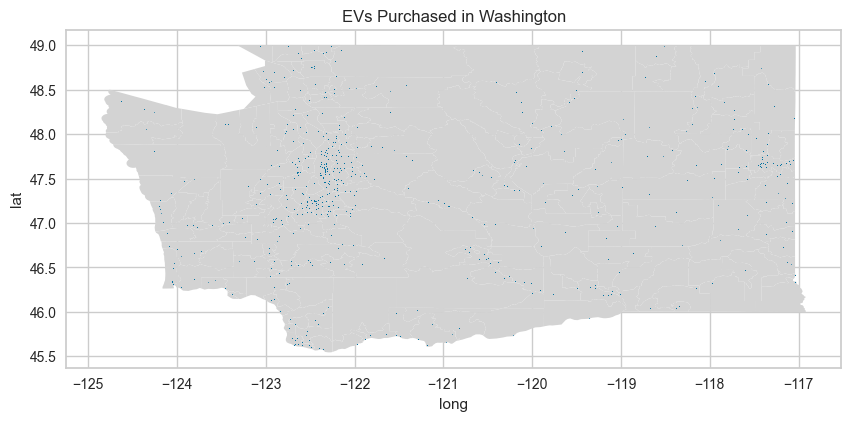

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
wash.plot(color="lightgrey", ax=ax)
electric_vehicle_df.plot(x='long', y='lat', kind="scatter", 
        title="EVs Purchased in Washington",
        s=.1,
        ax=ax)
plt.show();

In [11]:
electric_vehicle_df.head()

,Model Year,Make,Electric Vehicle Type,make_encoded,type_encoded,long,lat
0,2020,HYUNDAI,Battery Electric Vehicle (BEV),13,0,-122.343010,47.659185
1,2022,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),15,1,-122.205780,47.762405
2,2023,JEEP,Plug-in Hybrid Electric Vehicle (PHEV),15,1,-120.602720,46.596562
3,2018,TESLA,Battery Electric Vehicle (BEV),31,0,-122.209285,47.711240
4,2018,BMW,Plug-in Hybrid Electric Vehicle (PHEV),4,1,-122.896920,47.043535


### Determine number of clusters using elbow method (Sum of squared distance to center)

In [12]:
X = electric_vehicle_df[electric_vehicle_df.columns[5:7]]
X


,long,lat
0,-122.343010,47.659185
1,-122.205780,47.762405
2,-120.602720,46.596562
3,-122.209285,47.711240
4,-122.896920,47.043535
...,...,...
150477,-123.605350,46.982215
150478,-122.329075,47.601800
150479,-122.348480,47.632405
150480,-122.308420,47.784160


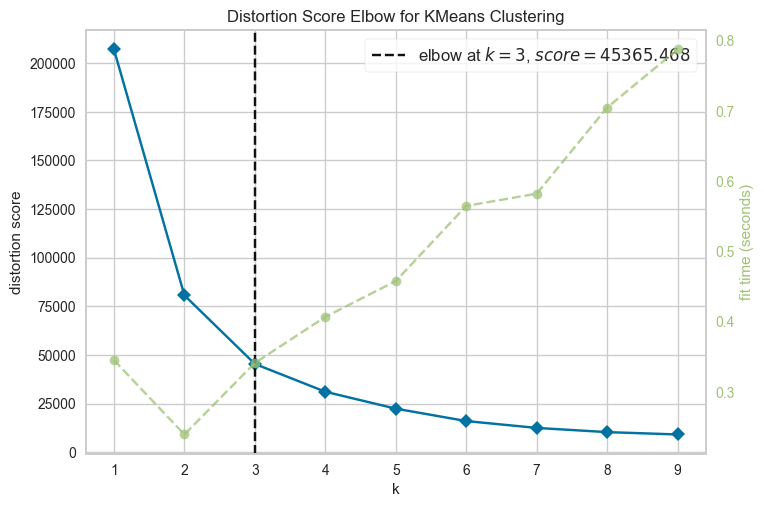

In [13]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,10), metric='distortion')

visualizer.fit(X)
visualizer.show();

In [14]:
kmeans = KMeans(n_clusters = 3, n_init=10, init ='k-means++')
kmeans.fit(X)
electric_vehicle_df['cluster_label'] = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
labels = kmeans.predict(X)

C:\Users\mike\AppData\Local\Temp\ipykernel_5144\2527558282.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('tab10', 3),


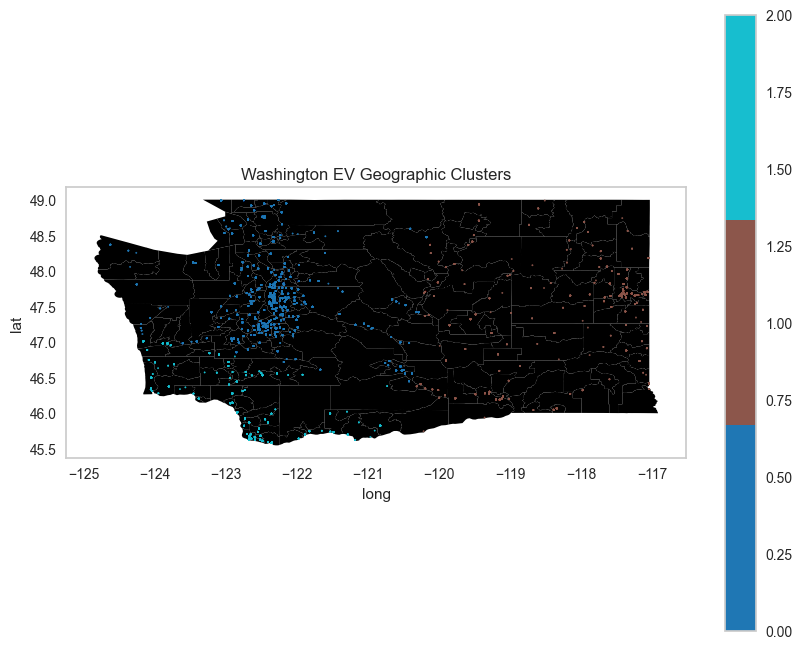

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
wash.plot(color="black", ax=ax)
electric_vehicle_df.plot(x='long', y='lat', kind="scatter", 
        title="Washington EV Geographic Clusters",
        s=1,
        c=labels,
        cmap=cm.get_cmap('tab10', 3),
        ax=ax)
ax.grid(False)
plt.show();

In [16]:
df = electric_vehicle_df
df0 = df.loc[df['cluster_label'] == 0]
df1 = df.loc[df['cluster_label'] == 1]
df2 = df.loc[df['cluster_label'] == 2]

## Compare vehicle makes and types between clusters

### Overall

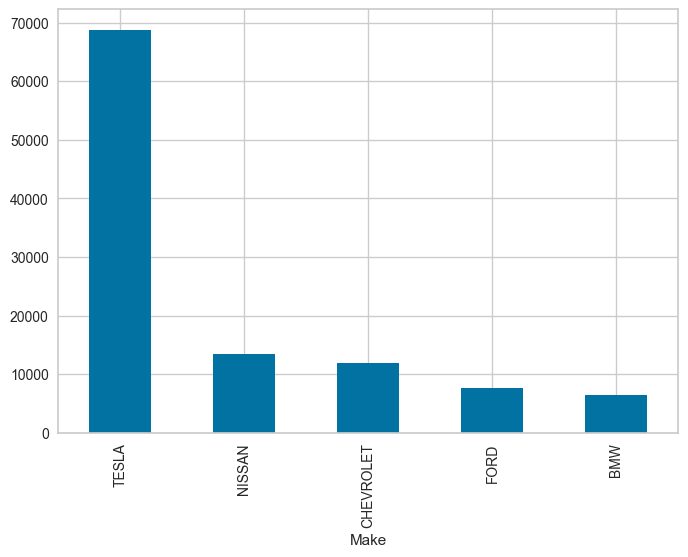

In [17]:
df.Make.value_counts().head(5).plot(kind='bar');

In [18]:
df['Electric Vehicle Type'].value_counts() / len(df)

Electric Vehicle Type
Battery Electric Vehicle (BEV)            0.776511
Plug-in Hybrid Electric Vehicle (PHEV)    0.223489
Name: count, dtype: float64

### Cluster 0 (Vancouver)

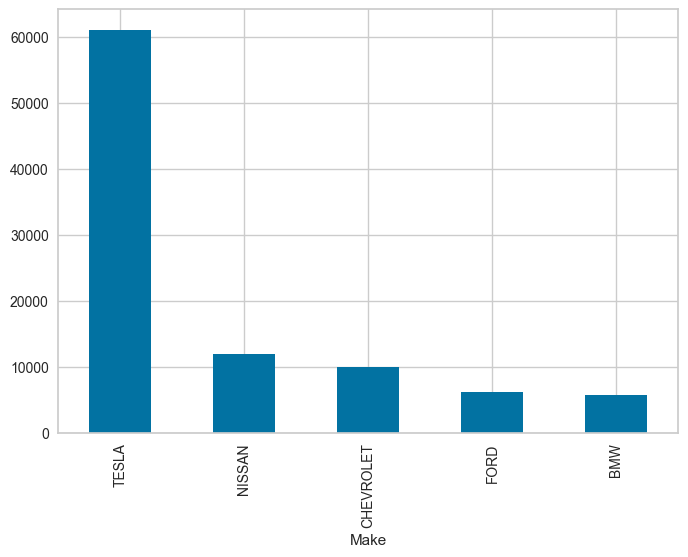

In [19]:
df0.Make.value_counts().head(5).plot(kind='bar');

In [20]:
df0['Electric Vehicle Type'].value_counts() / len(df0)

Electric Vehicle Type
Battery Electric Vehicle (BEV)            0.787995
Plug-in Hybrid Electric Vehicle (PHEV)    0.212005
Name: count, dtype: float64

### Cluster 1 (Spokane)

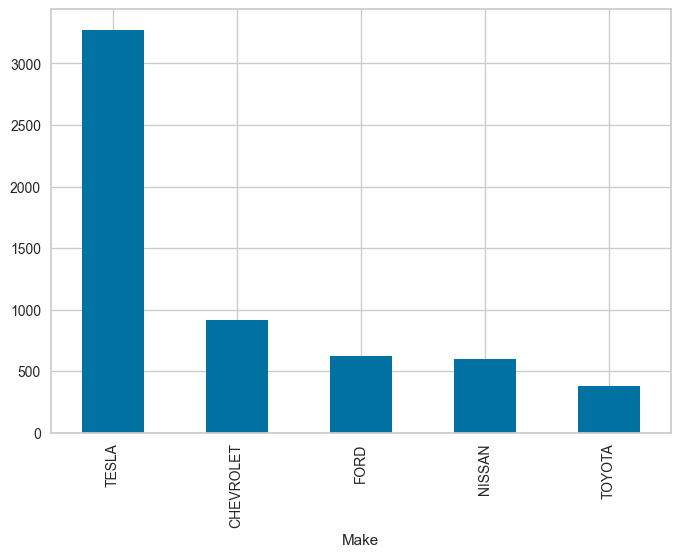

In [21]:
df1.Make.value_counts().head(5).plot(kind='bar');

In [22]:
df1['Electric Vehicle Type'].value_counts() / len(df1)

Electric Vehicle Type
Battery Electric Vehicle (BEV)            0.686532
Plug-in Hybrid Electric Vehicle (PHEV)    0.313468
Name: count, dtype: float64

### Cluster 2 (Seattle)

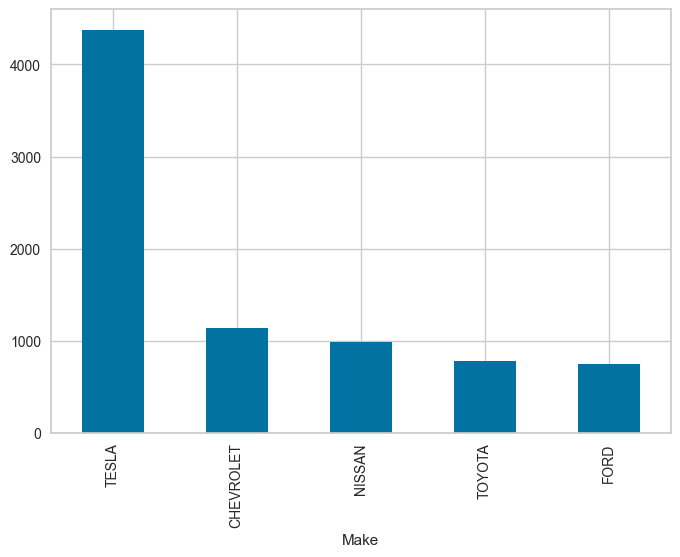

In [23]:
df2.Make.value_counts().head(5).plot(kind='bar');

In [24]:
df2['Electric Vehicle Type'].value_counts() / len(df2)

Electric Vehicle Type
Battery Electric Vehicle (BEV)            0.707642
Plug-in Hybrid Electric Vehicle (PHEV)    0.292358
Name: count, dtype: float64